# Bot Identification with K Means Clustering

### Package Imports

In [1]:
import snowflake.connector #must install this connector in order to connect to Snowflake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Connecting to Snowflake

In [2]:
#instantiate a connection object using the previously installed Snowflake connector
con = snowflake.connector.connect(
  user='xxxx',
  password='xxxx',
  account='xxxx',
  warehouse='xxxx',
  database='xxxx',
  schema='xxxx'
)

### Query Snowflake

In [3]:
#define query 
query = """
select * 
from BDW.AA_ACTV_GA_SESSION_F
limit 10000;
"""

#assign query results to the "data" dataframe
df = pd.read_sql_query(query, con)  #notice the Snowflake query was passed into the read_sql_query() method 

#use head() method to print first 5 columns of the dataframe
df.head()

,SESSION_SK,ELT_TS,BRAND_PROPERTY_SK,VISITOR_SK,VISIT_NBR,SOURCE_CD,SESSION_START_DTM,SESSION_END_DTM,SESSION_DURATION_MIN,CHANNEL_SK,...,BROWSER_SK,ENTRY_PAGE_SK,EXIT_PAGE_SK,GEO_CITY_SK,NETWORK_DOMAIN_NM,SESSION_BOUNCED_IND,SESSION_HIT_CNT,SESSION_TRANSACTION_VALUE_AMT,SESSION_TRANSACTION_CNT,ELT_BY
0,6516515,2019-08-15 00:02:18.165000+00:00,20,251130,1726,ga,2019-08-13 19:21:18+00:00,2019-08-13 19:21:18+00:00,0,3,...,2405,-1,26850,-1,(not set),0,10,0.0,0,aa_actv_ga_session_hit_elt
1,6574045,2019-08-15 00:02:18.165000+00:00,20,2053135,2,ga,2019-08-13 12:41:10+00:00,2019-08-13 12:41:10+00:00,0,3,...,88,401249,401249,-1,apexogilvy.com,1,4,0.0,0,aa_actv_ga_session_hit_elt
2,6713275,2019-08-15 00:02:18.165000+00:00,20,444588,89,ga,2019-08-13 20:19:40+00:00,2019-08-13 20:19:40+00:00,0,3,...,2529,143,143,-1,(not set),1,6,0.0,0,aa_actv_ga_session_hit_elt
3,6758009,2019-08-15 00:02:18.165000+00:00,20,1894185,9,ga,2019-08-14 00:13:39+00:00,2019-08-14 00:15:39+00:00,2,9,...,2529,-1,-1,-1,zoominternet.net,0,26,0.0,0,aa_actv_ga_session_hit_elt
4,6438233,2019-08-15 00:02:18.165000+00:00,20,589686,126,ga,2019-08-14 06:08:11+00:00,2019-08-14 06:08:11+00:00,0,3,...,86,-1,-1,-1,telesp.net.br,1,5,0.0,0,aa_actv_ga_session_hit_elt


In [4]:
df.shape

(10000, 22)

In [5]:
df.describe()

,SESSION_SK,BRAND_PROPERTY_SK,VISITOR_SK,VISIT_NBR,SESSION_DURATION_MIN,CHANNEL_SK,TRAFFIC_SOURCE_SK,DEVICE_SK,BROWSER_SK,ENTRY_PAGE_SK,EXIT_PAGE_SK,GEO_CITY_SK,SESSION_BOUNCED_IND,SESSION_HIT_CNT,SESSION_TRANSACTION_VALUE_AMT,SESSION_TRANSACTION_CNT
count,1.000000e+04,10000.0,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,6.497423e+06,20.0,1.566923e+06,101.142000,4.314700,4.515400,2444.694200,623.423500,1292.274900,79789.596500,57196.581700,-1.0,0.324200,21.175500,1.682106e+06,0.018600
std,1.574017e+05,0.0,6.881643e+05,329.234245,11.459389,2.770764,7732.235901,2339.982359,1226.441082,160594.460006,141770.002978,0.0,0.468099,35.699691,1.755466e+07,0.138766
min,6.222357e+06,20.0,1.001000e+03,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,-1.000000,-1.000000,-1.0,0.000000,1.000000,0.000000e+00,0.000000
25%,6.361653e+06,20.0,1.219830e+06,1.000000,0.000000,3.000000,3.000000,14.000000,12.000000,-1.000000,-1.000000,-1.0,0.000000,5.000000,0.000000e+00,0.000000
50%,6.499704e+06,20.0,1.897412e+06,5.000000,0.000000,3.000000,10.000000,20.000000,1249.500000,-1.000000,-1.000000,-1.0,0.000000,10.000000,0.000000e+00,0.000000
75%,6.634505e+06,20.0,2.003815e+06,46.000000,2.000000,6.000000,50.000000,39.000000,2529.000000,16999.000000,1590.000000,-1.0,1.000000,21.000000,0.000000e+00,0.000000
max,6.766998e+06,20.0,2.129640e+06,7055.000000,181.000000,12.000000,38393.000000,21940.000000,3217.000000,533873.000000,533994.000000,-1.0,1.000000,500.000000,5.284900e+08,2.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
SESSION_SK                       10000 non-null int64
ELT_TS                           10000 non-null datetime64[ns, UTC]
BRAND_PROPERTY_SK                10000 non-null int64
VISITOR_SK                       10000 non-null int64
VISIT_NBR                        10000 non-null int64
SOURCE_CD                        10000 non-null object
SESSION_START_DTM                10000 non-null datetime64[ns, UTC]
SESSION_END_DTM                  10000 non-null datetime64[ns, UTC]
SESSION_DURATION_MIN             10000 non-null int64
CHANNEL_SK                       10000 non-null int64
TRAFFIC_SOURCE_SK                10000 non-null int64
DEVICE_SK                        10000 non-null int64
BROWSER_SK                       10000 non-null int64
ENTRY_PAGE_SK                    10000 non-null int64
EXIT_PAGE_SK                     10000 non-null int64
GEO_CITY_SK                      10000 

Possible two features to use for the K Means Model: SESSION_HIT_CNT, SESSION_DURATION_MIN

In [7]:
from sklearn.cluster import KMeans

### Using the Elbow Method

There isn't always a "correct" number of clusters to be used in a K Means clustering approach. Nonetheless, one method to optimize the number of clusters is the elbow method, in which we calculate the Within Cluster Sum of Squares (WCSS) for a range of k values. WCSS is the average of the sum of squared euclidean distances between every point and its related centroid. Once the WCSS values are calculated, we can choose the k-value that has reasonably reduced the WCSS value, which is visualized as the elbow point below.  

Text(0, 0.5, 'WCSS')

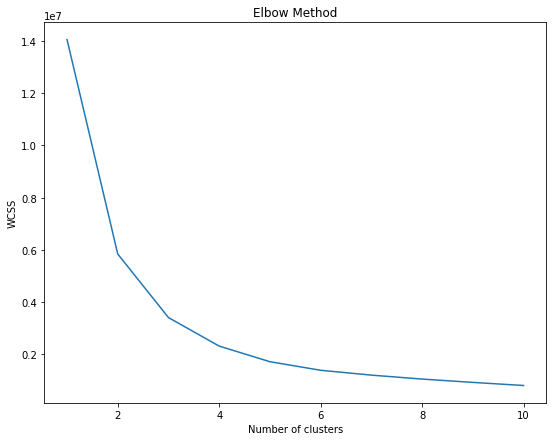

In [8]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[['SESSION_HIT_CNT','SESSION_DURATION_MIN']])
    #use the kmeans.inertia_ attribute to get the WCSS value
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(9,7))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
#Within Cluster Sum of Squares
plt.ylabel('WCSS')

We've landed on k=4, but that doesn't necessarily stop us from trying other k-values.  

### Clustering and Visualization

In [25]:
#instantiating k means model
km = KMeans(n_clusters=4)

#training the model
km.fit(df[['SESSION_HIT_CNT','SESSION_DURATION_MIN']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

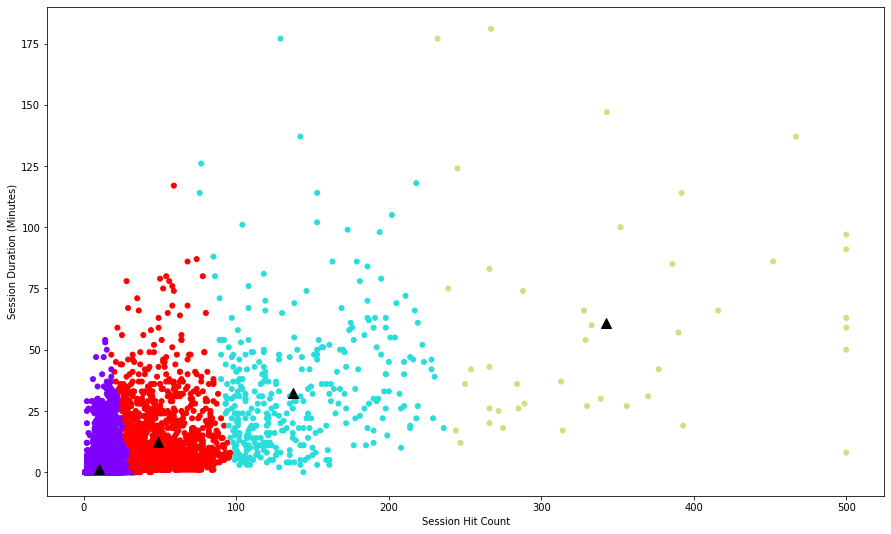

In [26]:
plt.figure(figsize=(15,9))
plt.xlabel("Session Hit Count")
plt.ylabel("Session Duration (Minutes)")

#plot clusters according to K Means
plt.scatter(df.SESSION_HIT_CNT, df.SESSION_DURATION_MIN, s=25, c=km.labels_, cmap='rainbow')

#plot centroids as triangles
centroids = np.array(km.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker='^', s=100, color='black')